In [75]:
import random
import numpy as np
import seaborn as sns
import math
import os
import time
import multiprocessing
from decimal import Decimal
import matplotlib.pyplot as plt
import traceback
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import norm
from select_sensor import SelectSensor
from sensor import Sensor
from joblib import Memory, Parallel, delayed
%matplotlib inline

In [53]:
start = time.time()

selectsensor = SelectSensor('config.json')

selectsensor.read_init_sensor('data/sensor.txt')
selectsensor.read_mean_std('data/mean_std.txt')
selectsensor.compute_multivariant_gaussian('data/artificial_samples.csv')

subset_list = selectsensor.select_offline_greedy(5)
print('The selected subset is: ', subset_list)

print('time elapsed:', time.time()-start)

Computed covariance!
[0] 0.0166434544566
[1] 0.0129393306223
[2] 0.0165262357847
[3] 0.0141985524828
[4] 0.0108603993687
[5] 0.0111011826022
[6] 0.0102953855245
[7] 0.0147877462679
[8] 0.0167445501893
[9] 0.0155235920825
[10] 0.012660428033
[11] 0.0121858146591
[12] 0.0102195031677
[13] 0.00978124151763
[14] 0.0237937312591
[15] 0.013729890385
[16] 0.0158147795756
[17] 0.01165224123
[18] 0.0198806698734
[19] 0.0101222680479
[0, 14] 0.135293070248
[1, 14] 0.243360825596
[2, 14] 0.197714035746
[3, 14] 0.155870182349
[4, 14] 0.177980837284
[5, 14] 0.321260296624
[6, 14] 0.281379432808
[7, 14] 0.157376392437
[8, 14] 0.243329916834
[9, 14] 0.273156922763
[10, 14] 0.256020635737
[11, 14] 0.302540686694
[12, 14] 0.257390958426
[13, 14] 0.127444404573
[14, 15] 0.104903226602
[14, 16] 0.184608437475
[14, 17] 0.173271874648
[14, 18] 0.25062809301
[14, 19] 0.258306791083
[0, 5, 14] 0.440125699419
[1, 5, 14] 0.769800228593
[2, 5, 14] 0.703490683749
[3, 5, 14] 0.632895142518
[4, 5, 14] 0.7428423972

In [2]:
start = time.time()

selectsensor = SelectSensor('config.json')

selectsensor.read_init_sensor('data/sensor.txt')
selectsensor.read_mean_std('data/mean_std.txt')
selectsensor.compute_multivariant_gaussian('data/artificial_samples.csv')

subset_list = selectsensor.select_offline_greedy_p(5, 2)
print('The selected subset is: ', subset_list)

print('time elapsed:', time.time()-start)

Computed covariance!
[0] 0.0166434544566
[1] 0.0129393306223
[2] 0.0165262357847
[3] 0.0141985524828
[4] 0.0108603993687
[5] 0.0111011826022
[6] 0.0102953855245
[7] 0.0147877462679
[8] 0.0167445501893
[9] 0.0155235920825
[10] 0.012660428033
[11] 0.0121858146591
[12] 0.0102195031677
[13] 0.00978124151763
[14] 0.0237937312591
[15] 0.013729890385
[16] 0.0158147795756
[17] 0.01165224123
[18] 0.0198806698734
[19] 0.0101222680479
[0, 14] 0.135293070248
[1, 14] 0.243360825596
[2, 14] 0.197714035746
[3, 14] 0.155870182349
[4, 14] 0.177980837284
[5, 14] 0.321260296624
[6, 14] 0.281379432808
[7, 14] 0.157376392437
[8, 14] 0.243329916834
[9, 14] 0.273156922763
[10, 14] 0.256020635737
[11, 14] 0.302540686694
[12, 14] 0.257390958426
[13, 14] 0.127444404573
[14, 15] 0.104903226602
[14, 16] 0.184608437475
[14, 17] 0.173271874648
[14, 18] 0.25062809301
[14, 19] 0.258306791083
[0, 5, 14] 0.440125699419
[1, 5, 14] 0.769800228593
[2, 5, 14] 0.703490683749
[3, 5, 14] 0.632895142518
[4, 5, 14] 0.7428423972

In [9]:
#visualize the sensors and errors

sensors = {}
with open('data/sensor.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.split(' ')
        x, y, std = int(line[0]), int(line[1]), float(line[2])
        sensors[(x, y)] = Sensor(x, y, std)
        
grid = np.zeros((15, 15))
for sensor in sensors:
    x, y = sensor[0], sensor[1]
    grid[x][y] = 1

with open('data/higherror.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('(', '')
        line = line.replace(', ', ' ')
        line = line.replace(') ', '')
        line = line.strip()
        line = line.split(' ')
        x, y, e = int(line[0]), int(line[1]), float(line[2])
        if e > 0:
            if grid[x][y] > 0.99:
                grid[x][y] = 0.5
            else:
                grid[x][y] = -e/10

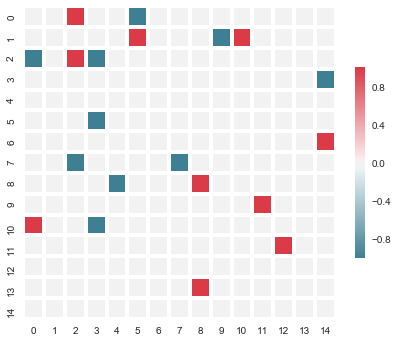

In [30]:
sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(grid, cmap=cmap, vmax=1, center=0,
            square=True, linewidth=3, cbar_kws={"shrink": .5})

plt.show()

In [29]:
# visualize selected and not selected sensors

sensors = {}
with open('data/sensor.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.split(' ')
        x, y, std = int(line[0]), int(line[1]), float(line[2])
        sensors[(x, y)] = Sensor(x, y, std)
        
grid = np.zeros((15, 15))
selected = [0, 3, 6, 8, 9, 12, 15, 17, 18, 19]
i, j = 0, 0
for sensor in sensors:
    x, y = sensor[0], sensor[1]
    if i == selected[j]:
        grid[x][y] = 1
        j += 1
    else:
        grid[x][y] = -1
    i += 1

In [117]:
def mean(dist):
    return 100 - 19.6*math.log(2*dist)

In [63]:
energy = pd.read_csv('data/energy.txt', header=None)
energy = energy.iloc[np.random.permutation(energy.index)]
energy

,0,1
0,1024,0.841995
7,64,0.792529
2,2048,0.882824
5,4096,1.000000
1,128,0.804355
6,512,0.820576
3,256,0.810056
4,32,0.782156


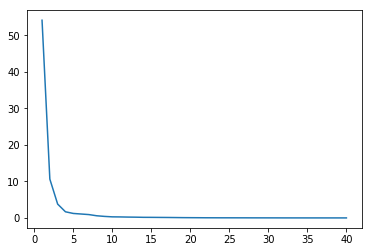

In [117]:
data = pd.read_csv('plot_data2/Offline_Random_30.csv', header=None)
X = list(data[0])
Y = list(data[1])
plt.plot(X, Y)

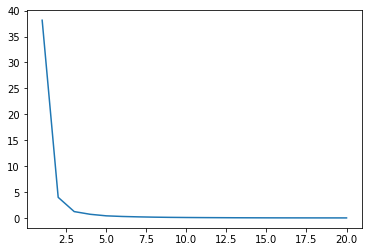

In [118]:
data = pd.read_csv('plot_data2/Offline_Greedy_30.csv', header=None)
X = list(data[0])
Y = list(data[1])
plt.plot(X, Y)

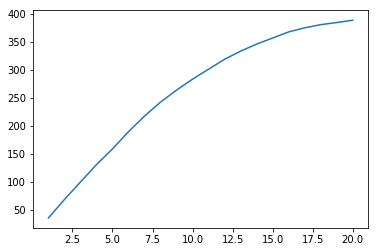

In [116]:
data = pd.read_csv('plot_data2/Latency_20.csv', header=None)
X = list(data[0])
Y = list(data[1])
plt.plot(X, Y)

In [92]:
mean(29*math.sqrt(2))

2.1642314616541114

In [101]:
random.seed(0)
for i in range(9):
    print(random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9]))

7
7
1
5
9
8
7
5
8


In [105]:
approx = pd.read_csv('plot_data2/test_of_approx.csv', header=None)

In [106]:
approx

,0,1
0,1,-8.827051
1,2,-0.123268
2,3,0.691544
3,4,0.908960
4,5,0.952367
5,6,0.968814
6,7,0.981200
7,8,0.987472
8,9,0.991710
9,10,0.994356


In [110]:
for i in range(len(approx[1])-2):
    print(approx[1][i+1] - approx[1][i])

8.70378249163
0.81481197244
0.217416098995
0.043407689242
0.01644699347
0.012385384393
0.006272078407
0.004238064961


In [113]:
for i in range(2, 20, 2):
    print(i)

2
4
6
8
10
12
14
16
18
